In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

C:\Users\JOSHWIN ISAC\AppData\Local\Temp\ipykernel_24104\3029127538.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

In [3]:
import os
import cv2
test_path="D:\\dataset for lab programs\\data\\test"
classes= sorted(os.listdir(test_path))

# Count the number of classes
num_classes = len(classes)

# Print the class names and the total number of classes
print("Class Names: \n", classes)
print("Number of Classes:", num_classes)

Class Names: 
 ['benign', 'malignant']
Number of Classes: 2


In [4]:
import os
import cv2
train_path="D:\\dataset for lab programs\\data\\train"
classes= sorted(os.listdir(test_path))

# Count the number of classes
num_classes = len(classes)

# Print the class names and the total number of classes
print("Class Names: \n", classes)
print("Number of Classes:", num_classes)

Class Names: 
 ['benign', 'malignant']
Number of Classes: 2


In [5]:
img_width, img_height = 224, 224

In [6]:
def load_images(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith(".jpg"):
                img = cv2.imread(os.path.join(label_dir, filename))
                img = cv2.resize(img, (img_width, img_height))
                images.append(img)
                if label == 'benign':
                    labels.append(0)
                else:
                    labels.append(1)
    return images, labels

train_images, train_labels = load_images(train_path)
test_images, test_labels = load_images(test_path)

In [7]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [8]:
#normalizing thr\e pixels

train_images = train_images / 255.0
test_images = test_images / 255.0

In [9]:
# Data augmentation for training data
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generate augmented training data
train_data_generator.fit(train_images)


In [10]:
# Data augmentation for training data
test_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Generate augmented training data
test_data_generator.fit(test_images)


In [11]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [12]:

from tensorflow.keras.optimizers import Adam

In [13]:
# Load the pre-trained VGG16 model
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16.layers:
    layer.trainable = False

model_vgg16=Sequential()
model_vgg16.add(vgg16)
model_vgg16.add(Flatten())
model_vgg16.add(Dense(256,activation='relu'))
model_vgg16.add(Dense(128, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(2, activation='sigmoid'))

In [14]:
model_vgg16.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [15]:
model_vgg16.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

validation_generator = test_data_generator.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [18]:
# Train the model
history = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.n // 32,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.n //32)

Epoch 1/10


c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.6703 - loss: 0.7525 - val_accuracy: 0.7984 - val_loss: 0.4295
Epoch 2/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 3:06 2s/step - accuracy: 0.8438 - loss: 0.4137

c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8438 - loss: 0.2094 - val_accuracy: 0.9000 - val_loss: 0.1470
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 667s 8s/step - accuracy: 0.7849 - loss: 0.4452 - val_accuracy: 0.8297 - val_loss: 0.3691
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9062 - loss: 0.1392 - val_accuracy: 0.7500 - val_loss: 0.1964
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 238s 3s/step - accuracy: 0.8227 - loss: 0.3740 - val_accuracy: 0.8313 - val_loss: 0.3599
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8750 - loss: 0.1316 - val_accuracy: 0.9000 - val_loss: 0.1429
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.8281 - loss: 0.3698 - val_accuracy: 0.8125 - val_loss: 0.4034
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.7812 - loss: 0.2225 - val_accuracy: 0.7500 - val_loss: 0.2475
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.8073 - loss: 0.4093 - val_accuracy: 0.8250 - val_loss: 0.

In [24]:
from tensorflow.keras.utils import to_categorical

# Assuming test_labels are integer labels
test_labels_one_hot = to_categorical(test_labels, num_classes=num_classes)

vgg16_loss, vgg16_accuracy = model_vgg16.evaluate(test_images, test_labels_one_hot)
print("VGG16 Test Accuracy:", vgg16_accuracy)

21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8219 - loss: 0.3148
VGG16 Test Accuracy: 0.8166666626930237


In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score,f1_score

vgg16_predictions = model_vgg16.predict(test_images)
vgg16_predictions = (vgg16_predictions > 0.5).astype(int)

print("Classification Report for VGG16:")
print(classification_report(test_labels_one_hot, vgg16_predictions))

21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step
Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       360
           1       0.81      0.79      0.80       300

   micro avg       0.83      0.81      0.82       660
   macro avg       0.83      0.81      0.82       660
weighted avg       0.83      0.81      0.82       660
 samples avg       0.81      0.81      0.81       660



c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


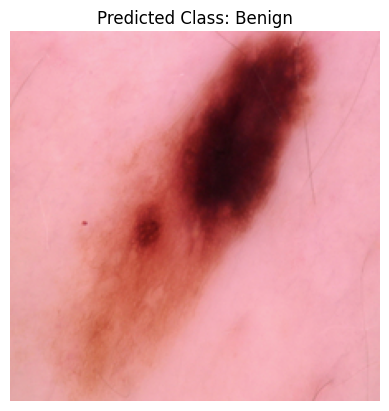

In [40]:
import cv2
import random
# Define the test dataset directory
test_path = "D:\\dataset for lab programs\\data\\test"

# Get a random image path from the test dataset
random_folder = random.choice(os.listdir(test_path))
random_image_path = os.path.join(test_path, random_folder, random.choice(os.listdir(os.path.join(test_path, random_folder))))

# Read and preprocess the randomly selected image
img = cv2.imread(random_image_path)
img = cv2.resize(img, (224, 224))
img = np.reshape(img, [1, 224, 224, 3])
img = img / 255

# Make predictions on the image
preds = model_vgg16.predict(img)
max_idx = np.argmax(preds)

# Define class indices
class_indices = {0: 'Benign', 1: 'Malignant'}  # Update with your class indices if needed

# Get the predicted class label
predicted_class = class_indices[max_idx]

# Plot the image with the predicted class label
plt.imshow(cv2.cvtColor(cv2.imread(random_image_path), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()

In [77]:

# Reset TensorFlow graph
tf.keras.backend.clear_session()

#Custom CNN
custom_CNNmodel=Sequential()
#add layers
custom_CNNmodel.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
custom_CNNmodel.add(MaxPooling2D(2,2))
custom_CNNmodel.add(Conv2D(64, (3, 3), activation='relu'))
custom_CNNmodel.add(MaxPooling2D(2,2))
custom_CNNmodel.add(Conv2D(128, (3, 3), activation='relu'))
custom_CNNmodel.add(MaxPooling2D(2,2))

custom_CNNmodel.add(Flatten())

custom_CNNmodel.add(Dense(512, activation='relu'))
custom_CNNmodel.add(Dropout(0.5))

custom_CNNmodel.add(Dense(1, activation='sigmoid'))


In [78]:
custom_CNNmodel.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
custom_CNNmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,396,609 (169.36 MB)

 Trainable params: 44,396,609 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [79]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

train_generator = train_data_generator.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')  

Found 2637 images belonging to 2 classes.


In [80]:
history = custom_CNNmodel.fit(train_generator,steps_per_epoch=train_generator.n // 32,epochs=10)

Epoch 1/10


c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 50s 561ms/step - accuracy: 0.5988 - loss: 1.1870
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 124us/step - accuracy: 0.8125 - loss: 0.2036 
Epoch 3/10


c:\Users\JOSHWIN ISAC\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 557ms/step - accuracy: 0.7369 - loss: 0.5060
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.8438 - loss: 0.2317  
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 48s 545ms/step - accuracy: 0.7928 - loss: 0.4361
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 64us/step - accuracy: 0.8750 - loss: 0.1545  
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 46s 530ms/step - accuracy: 0.7852 - loss: 0.4307
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 50us/step - accuracy: 0.8125 - loss: 0.1885  
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 47s 547ms/step - accuracy: 0.7911 - loss: 0.4307
Epoch 10/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 86us/step - accuracy: 0.7188 - loss: 0.2619  


In [70]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score,f1_score

custom_CNNmodel_predictions = custom_CNNmodel.predict(test_images)
custom_CNNmodel_predictions = (custom_CNNmodel_predictions > 0.5).astype(int)

print("Classification Report for custom_cnn:")
print(classification_report(test_labels, custom_CNNmodel_predictions))

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step
Classification Report for custom_cnn:
              precision    recall  f1-score   support

           0       1.00      0.10      0.18       360
           1       0.48      1.00      0.65       300

    accuracy                           0.51       660
   macro avg       0.74      0.55      0.42       660
weighted avg       0.76      0.51      0.39       660



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


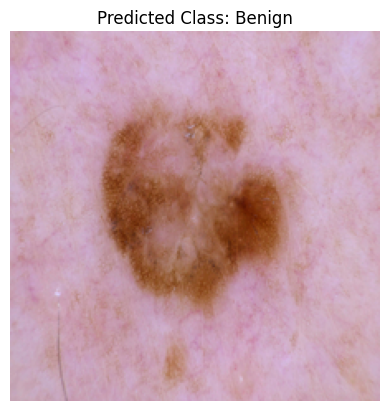

In [87]:
import cv2
import random
# Define the test dataset directory
test_path = "D:\\dataset for lab programs\\data\\test"

# Get a random image path from the test dataset
random_folder = random.choice(os.listdir(test_path))
random_image_path = os.path.join(test_path, random_folder, random.choice(os.listdir(os.path.join(test_path, random_folder))))

# Read and preprocess the randomly selected image
img = cv2.imread(random_image_path)
img = cv2.resize(img, (224, 224))
img = np.reshape(img, [1, 224, 224, 3])
img = img / 255

# Make predictions on the image
preds = custom_CNNmodel.predict(img)
max_idx = np.argmax(preds)

# Define class indices
class_indices = {0: 'Benign', 1: 'Malignant'}  # Update with your class indices if needed

# Get the predicted class label
predicted_class = class_indices[max_idx]

# Plot the image with the predicted class label
plt.imshow(cv2.cvtColor(cv2.imread(random_image_path), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()


Conclusion:

VGG16 architecture is performing good when comparing to CNN architecture. Test accuracy is around 81.6% for VGG16 and 71% for CNN model architecture. This shows that, VGG16 is performing well on testing data, that is unseen by the model. And for this dataset VGG16 model architecture is recommended to find interesting patterns of whether a person will develop a skin cancer or not